## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

## Funciones

In [2]:
class Graficador:

    def __init__(self):
        pass

    def create_subplots_one_var(self,data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)

        for column in data.columns:

            # Creacion del grafico de barras
            graph(data = data[[column]], ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

    def create_subplots_one_var_group(self, data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
        data_temp = data[::]
        data_temp['temp'] = 0
        for column in data_temp.columns:
            
            if column == 'temp':
                continue

            temp = data_temp[[column, 'temp']].groupby(column, as_index = False).count().rename(columns = {'temp' : 'Conteo'})
            # Creacion del grafico de barras
            graph(data = temp, x = column, y = 'Conteo', ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

def create_apilated_bars(data):

    grupos = data.columns

    fig, ax = plt.subplots()
    values = data.values

    for i in range(values.shape[0]):
        ax.bar(grupos, values[i], bottom = np.sum(values[:i], axis = 0), label = data.index[i])
        # Agregar títulos a los ejes

    return fig,ax


def outlier_label(value, limit):
    if value < limit[0]:
        return 'Abajo'
    elif value > limit[1]:
        return 'Arriba'
    else:
        return 'No'

def take_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    RIC = Q3 - Q1
    limit_inf = Q1 - (1.5 * RIC)
    limit_sup = Q3 + (1.5 * RIC)
    data[f'{variable}_outlier'] = data[variable].apply(lambda x: outlier_label(x, [limit_inf,limit_sup]))
    return data

## Parametros

In [3]:
client_bq = bigquery.Client()

In [4]:
table = 'Diabetes_avicena_survival.diabetes_final_4_annos'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

In [5]:
graficador = Graficador()

## Proceso

In [6]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (850302, 21) datos de pacientes


numero_identificacion_paciente  year  month       fecha  edad   peso  talla  \
0                       72045699  2021      2  2021-02-01    51  109.0   1.75   
1                       72131717  2021      2  2021-02-01    56   93.0   1.67   
2                       72138809  2021      2  2021-02-01    55  106.0   1.70   
3                       72148676  2021      2  2021-02-01    54   87.7   1.74   
4                       74359767  2021      2  2021-02-01    44   91.0   1.75   

            IMC   HDL    LDL  ...  perimetro_abdominal  genero_paciente  \
0  35.591836735  50.0  116.0  ...                118.0        Masculino   
1  33.346480691  39.5  108.0  ...                  NaN        Masculino   
2  36.678200692  30.0   65.0  ...                110.0        Masculino   
3  28.966838420  39.0  188.0  ...                104.0        Masculino   
4  29.714285714  33.0  140.0  ...                103.0        Masculino   

  raza_paciente nivel_academico_paciente ant_cardio  med_hipertension  \
0       Mestizo                  Ninguno          0                 0   
1         Otros               Normalista          1                 1   
2         Otros               Normalista          1                 1   
3         Otros              Profesional          1                 1   
4         Otros              Profesional          0                 0   

   ant_familiar_dm  hace_ejercicio diabetes  time_to_event  
0                0            None        0             40  
1                0            None        1              7  
2                0            None        0             39  
3                0            None        0             13  
4                0            None        0             47  

[5 rows x 21 columns]

In [7]:
# outliers

data_label = data.copy()
data_label['IMC'] = np.round(data_label['IMC'].astype(float),2)

for variable in variables_with_outliers:
    print(variable)
    data_label = take_outliers(data_label, variable)
    
for variable in variables_with_outliers:
    print(variable)
    conteos = data_label[f'{variable}_outlier'].value_counts().reset_index()
    total = conteos['count'].sum()
    conteos['Porcentaje'] = (conteos['count'] / total)*100
    display(conteos)
    
columns_to_drop = [column + '_outlier' for column in variables_with_outliers]

data_clean_outliers = data_label[(data_label.edad_outlier == 'No') &
                                 (data_label.IMC_outlier == 'No') &
                                 (data_label.HDL_outlier == 'No') &
                                 (data_label.LDL_outlier == 'No') &
                                 (data_label.trigliceridos_outlier == 'No') &
                                 (data_label.perimetro_abdominal_outlier == 'No')
                                ]

data_clean_outliers = data_clean_outliers.drop(columns = columns_to_drop)
data_clean_outliers = data_clean_outliers.drop(columns = ['peso','talla'])

data_clean_outliers

edad
IMC
HDL
LDL
trigliceridos
perimetro_abdominal
edad


edad_outlier   count  Porcentaje
0           No  850196   99.987534
1       Arriba     106    0.012466

IMC


IMC_outlier   count  Porcentaje
0          No  828458   97.431030
1      Arriba   20803    2.446543
2       Abajo    1041    0.122427

HDL


HDL_outlier   count  Porcentaje
0          No  829438   97.546284
1      Arriba   20443    2.404205
2       Abajo     421    0.049512

LDL


LDL_outlier   count  Porcentaje
0          No  839314   98.707753
1      Arriba    9942    1.169232
2       Abajo    1046    0.123015

trigliceridos


trigliceridos_outlier   count  Porcentaje
0                    No  812794   95.588861
1                Arriba   37508    4.411139

perimetro_abdominal


perimetro_abdominal_outlier   count  Porcentaje
0                          No  844008   99.259792
1                      Arriba    5021    0.590496
2                       Abajo    1273    0.149712

numero_identificacion_paciente  year  month       fecha  edad    IMC  \
0                            72045699  2021      2  2021-02-01    51  35.59   
1                            72131717  2021      2  2021-02-01    56  33.35   
2                            72138809  2021      2  2021-02-01    55  36.68   
3                            72148676  2021      2  2021-02-01    54  28.97   
4                            74359767  2021      2  2021-02-01    44  29.71   
...                               ...   ...    ...         ...   ...    ...   
850296                        6513382  2025      1  2025-01-01    60  24.50   
850297                       79903419  2025      1  2025-01-01    47  28.51   
850298                       80159179  2025      1  2025-01-01    43  33.44   
850300                       88282786  2025      1  2025-01-01    48  31.07   
850301                        9056540  2025      1  2025-01-01    80  20.24   

          HDL     LDL  trigliceridos  perimetro_abdominal genero_paciente  \
0       50.00  116.00         301.00                118.0       Masculino   
1       39.50  108.00         225.00                  NaN       Masculino   
2       30.00   65.00         168.00                110.0       Masculino   
3       39.00  188.00         143.00                104.0       Masculino   
4       33.00  140.00         220.00                103.0       Masculino   
...       ...     ...            ...                  ...             ...   
850296  56.00  127.00         185.00                 94.0       Masculino   
850297  39.00  127.00         194.00                 90.0       Masculino   
850298  40.60  157.67         147.63                110.3       Masculino   
850300  55.26  129.32         277.10                  NaN       Masculino   
850301  50.00  207.00         127.00                  NaN       Masculino   

       raza_paciente nivel_academico_paciente  ant_cardio  med_hipertension  \
0            Mestizo                  Ninguno           0                 0   
1              Otros               Normalista           1                 1   
2              Otros               Normalista           1                 1   
3              Otros              Profesional           1                 1   
4              Otros              Profesional           0                 0   
...              ...                      ...         ...               ...   
850296         Otros     Bachillerato técnico           0                 1   
850297         Otros          Especialización           1                 1   
850298         Otros              Profesional           0                 0   
850300         Otros                  Ninguno           0                 0   
850301         Otros                  Ninguno           0                 1   

        ant_familiar_dm hace_ejercicio  diabetes  time_to_event  
0                     0           None         0             40  
1                     0           None         1              7  
2                     0           None         0             39  
3                     0           None         0             13  
4                     0           None         0             47  
...                 ...            ...       ...            ...  
850296                0           None         1             43  
850297                0           None         1             23  
850298                0           None         1              4  
850300                0           None         0              1  
850301                0           None         0              1  

[759276 rows x 19 columns]

In [8]:
## Cantidad de pacientes con diabetes
data[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()

diabetes  numero_identificacion_paciente
0         0                          656044
1         1                          194258

In [9]:
# data_clean_outliers.to_csv('datas_no_outliers.csv', sep = '|', index = False)

## Filtrar datos Categoricos y numericos

In [10]:
# Dataframe con los datos numericos
df_numerico = data_clean_outliers[numeric_columns]
df_numerico['IMC'] = np.round(df_numerico['IMC'].astype(float),2)

print(data_clean_outliers.shape)
df_numerico.head()

(759276, 19)


edad    IMC   HDL    LDL  trigliceridos  perimetro_abdominal  time_to_event
0    51  35.59  50.0  116.0          301.0                118.0             40
1    56  33.35  39.5  108.0          225.0                  NaN              7
2    55  36.68  30.0   65.0          168.0                110.0             39
3    54  28.97  39.0  188.0          143.0                104.0             13
4    44  29.71  33.0  140.0          220.0                103.0             47

In [11]:
# Dataframe con los datos categoricos
df_categorico = data_clean_outliers[categoric_columns + [target]].astype(str)

print(data_clean_outliers.shape)
df_categorico.head()

(759276, 19)


genero_paciente raza_paciente nivel_academico_paciente ant_cardio  \
0       Masculino       Mestizo                  Ninguno          0   
1       Masculino         Otros               Normalista          1   
2       Masculino         Otros               Normalista          1   
3       Masculino         Otros              Profesional          1   
4       Masculino         Otros              Profesional          0   

  med_hipertension ant_familiar_dm hace_ejercicio diabetes  
0                0               0           None        0  
1                1               0           None        1  
2                1               0           None        0  
3                1               0           None        0  
4                0               0           None        0

## One Variable

In [12]:
## informacion de la data
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 759276 entries, 0 to 850301
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   edad                 759276 non-null  Int64  
 1   IMC                  759276 non-null  float64
 2   HDL                  759276 non-null  float64
 3   LDL                  759276 non-null  float64
 4   trigliceridos        759276 non-null  float64
 5   perimetro_abdominal  302310 non-null  float64
 6   time_to_event        759276 non-null  Int64  
dtypes: Int64(2), float64(5)
memory usage: 47.8 MB


In [13]:
## Descripcion de los datos
df_numerico.describe()

edad            IMC            HDL            LDL  trigliceridos  \
count   759276.0  759276.000000  759276.000000  759276.000000  759276.000000   
mean   54.594964      27.492279      47.400483     117.153039     144.183023   
std    16.005205       4.308311      10.912672      36.909471      62.001114   
min         18.0      15.550000      15.600000      13.100000       0.000000   
25%         43.0      24.450000      39.400000      91.000000      97.000000   
50%         55.0      27.140000      46.100000     116.000000     132.800000   
75%         66.0      30.260000      54.000000     142.000000     181.000000   
max        100.0      39.450000      78.000000     219.850000     328.000000   

       perimetro_abdominal  time_to_event  
count        302310.000000       759276.0  
mean             92.479419      21.868668  
std              11.450215      13.563733  
min              61.000000            1.0  
25%              85.000000           10.0  
50%              92.000000           22.0  
75%             100.000000           33.0  
max             125.000000           48.0

Grafico de distribuciones


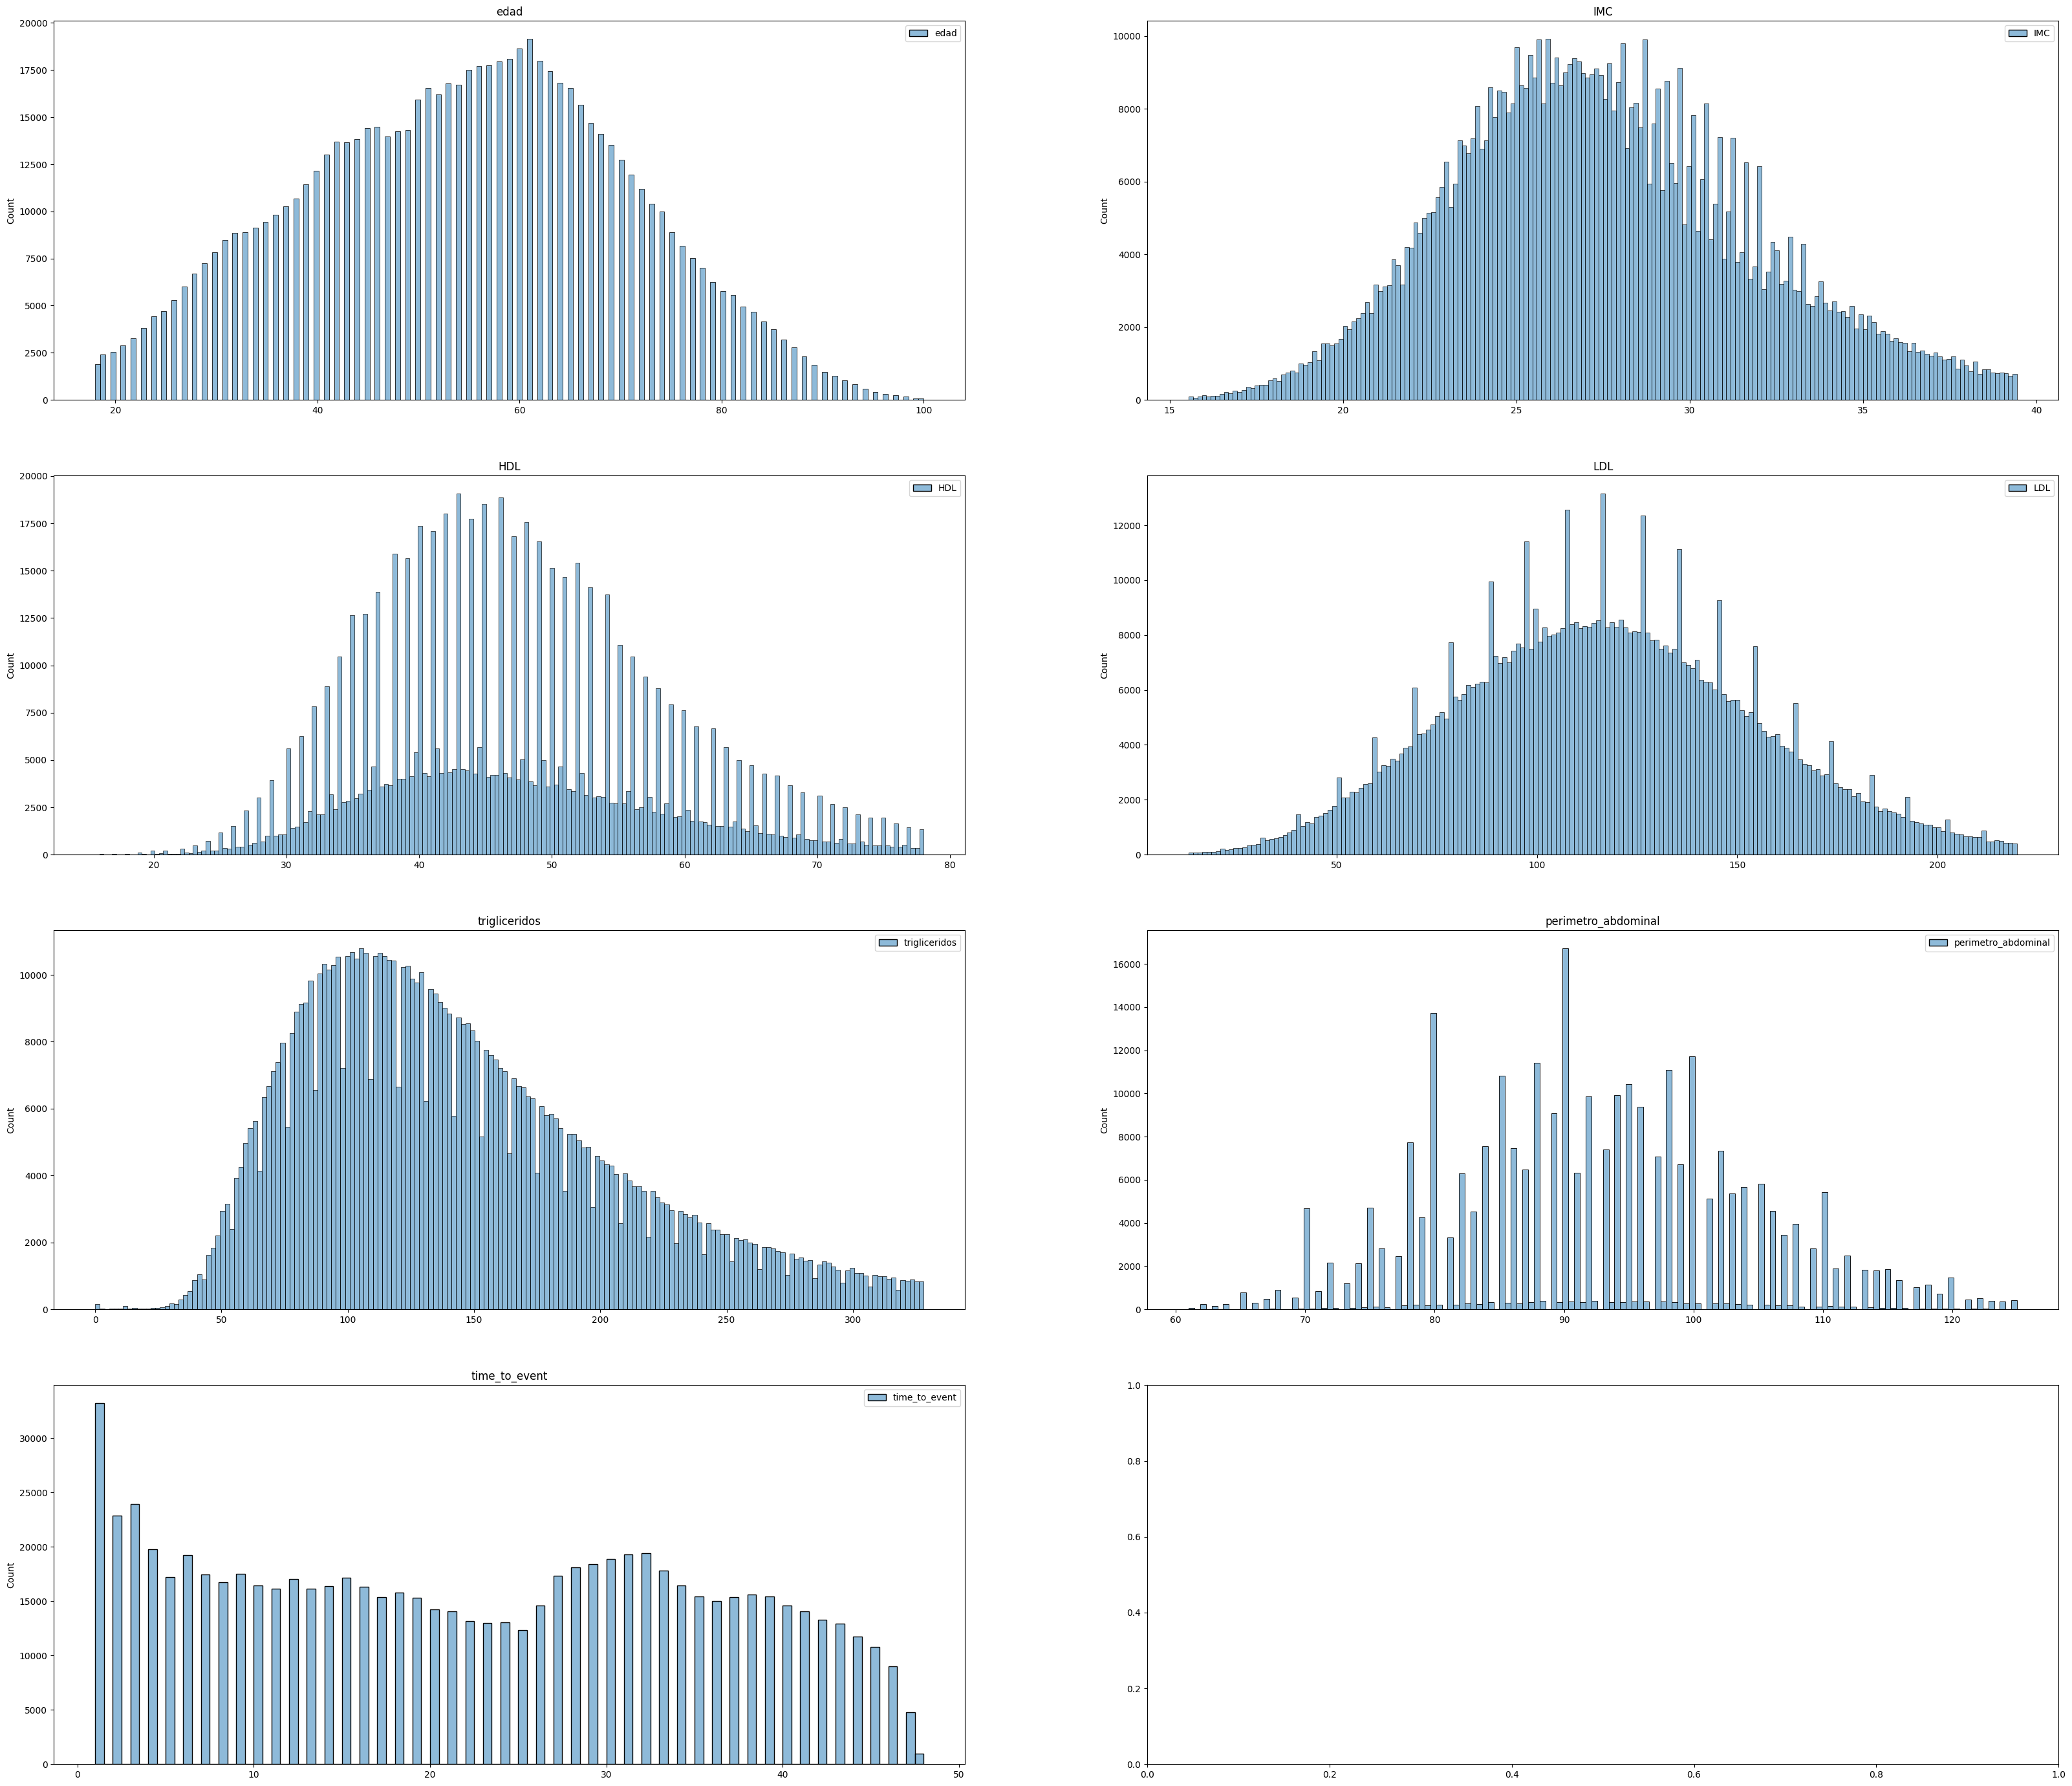

In [14]:
print('Grafico de distribuciones')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.histplot, fig_size = (40,35))
plt.show()

Grafico de caja y bigotes


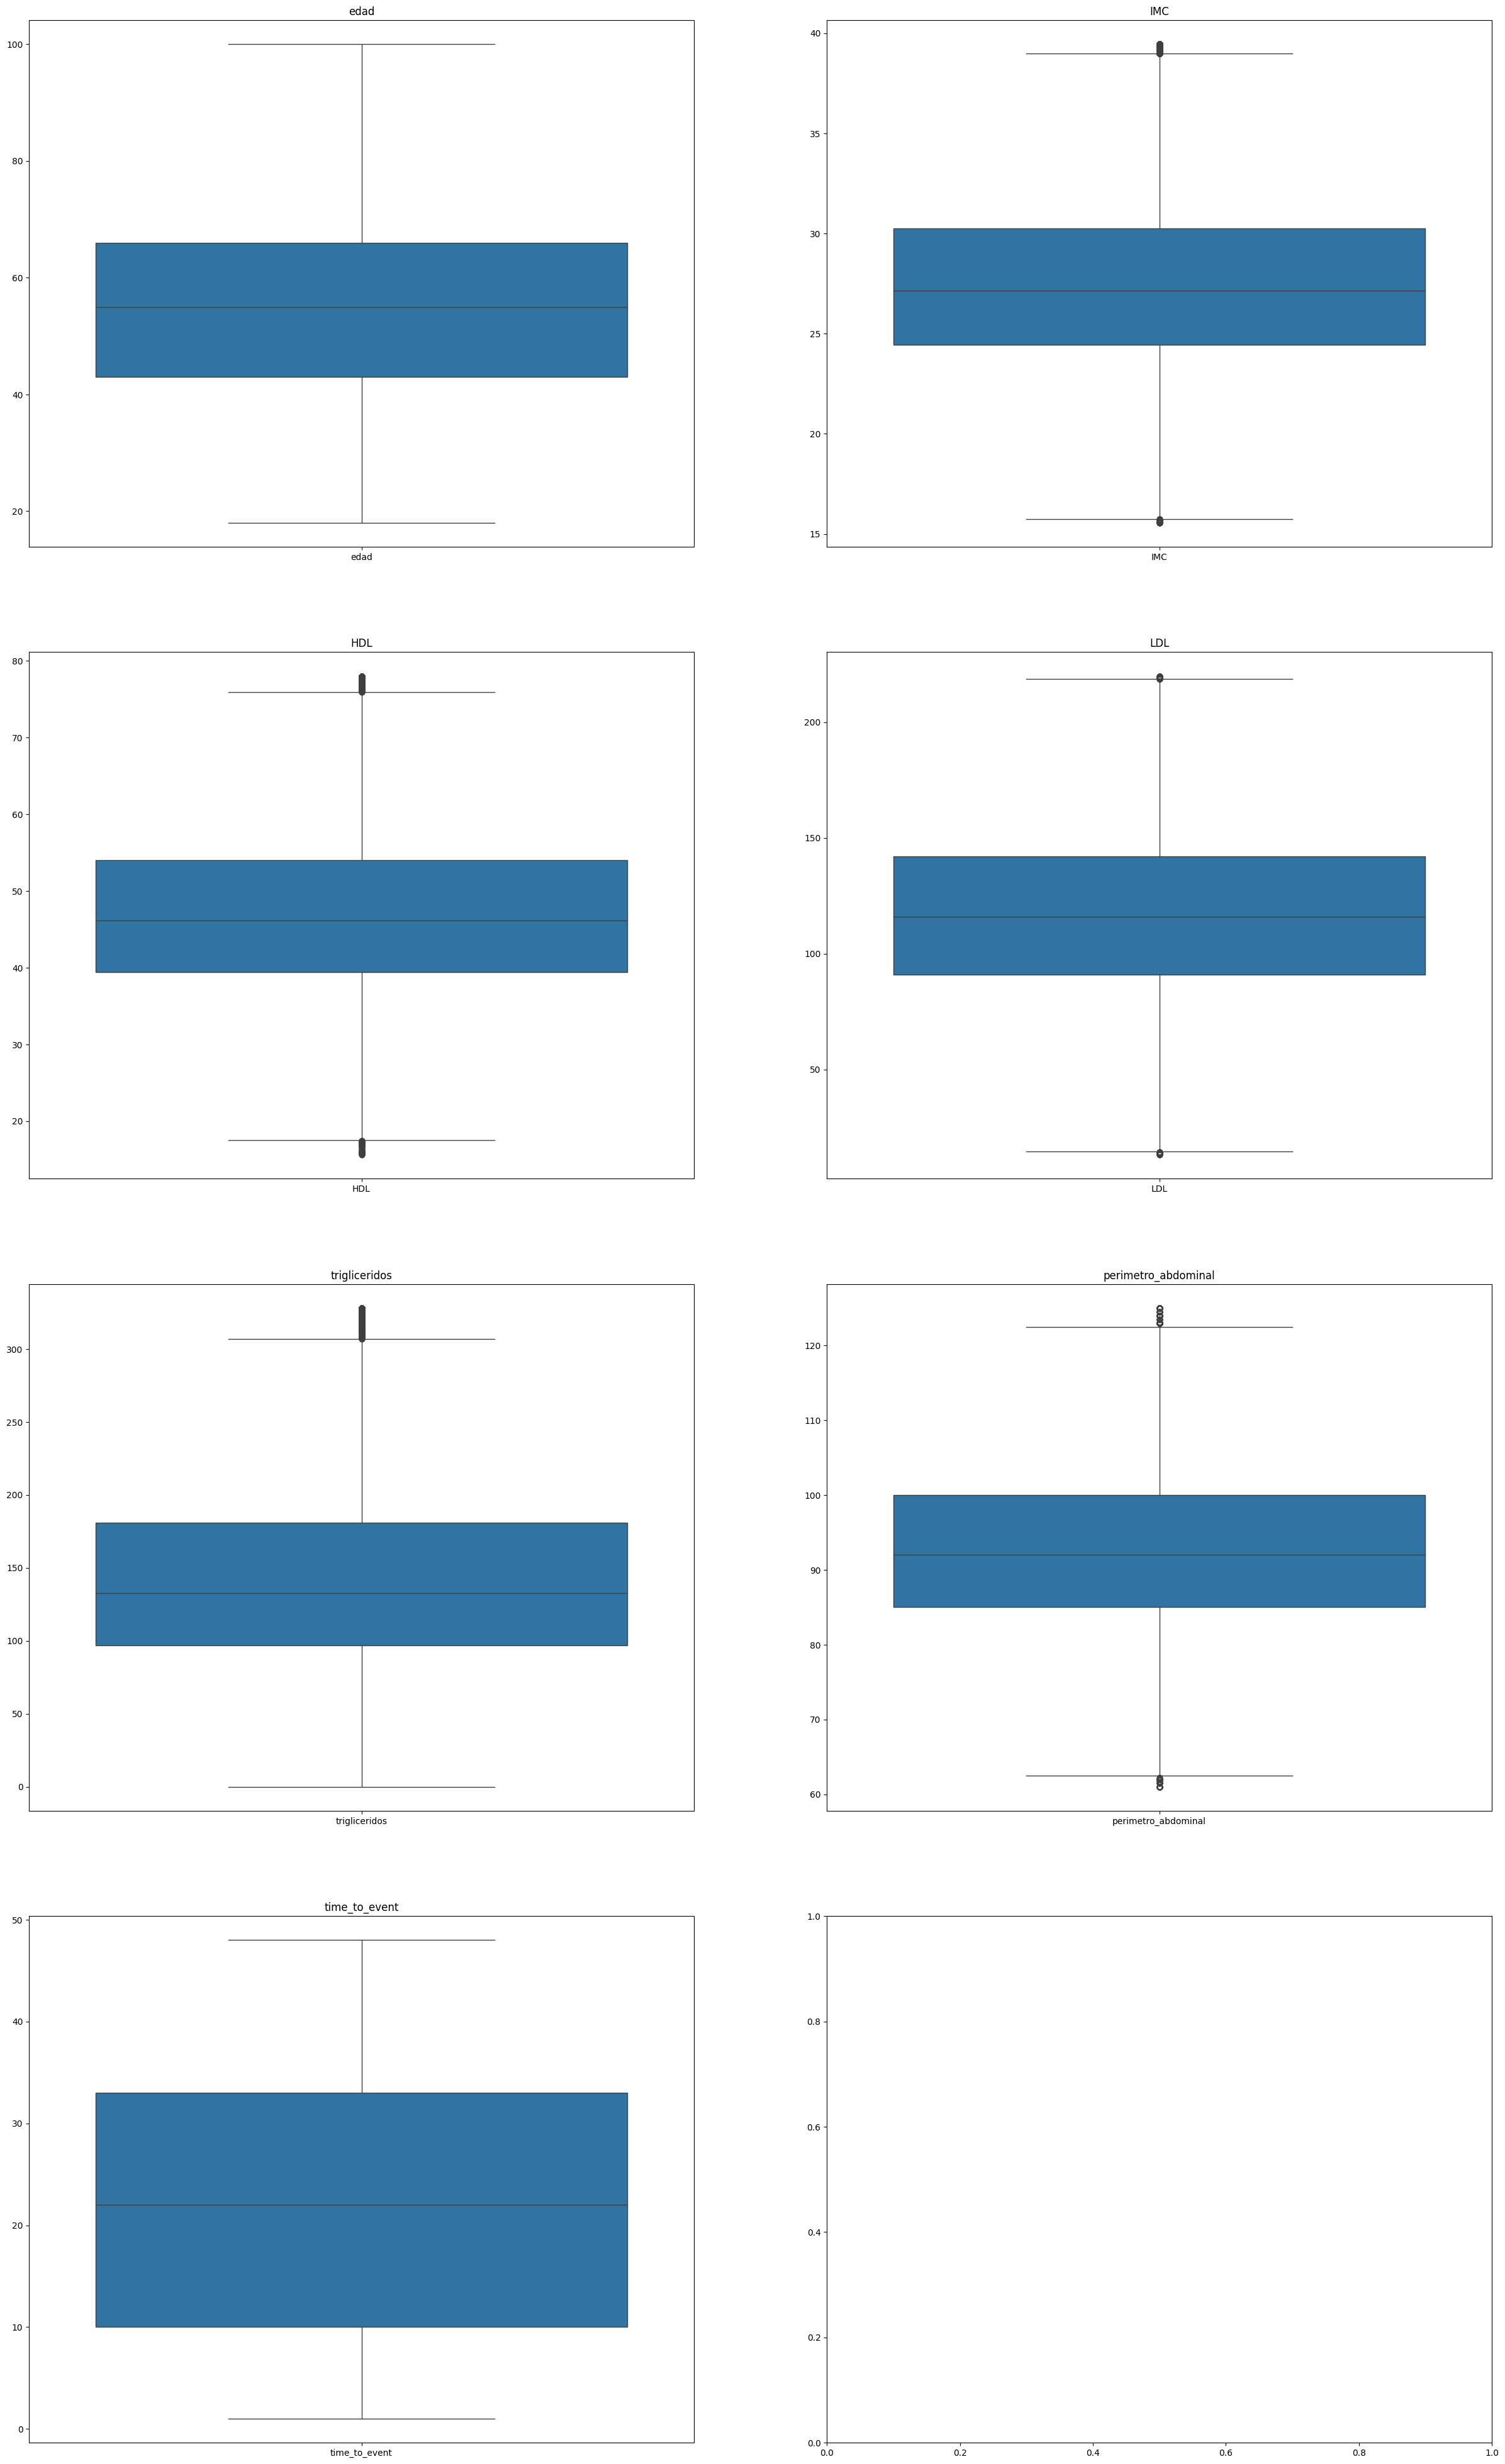

In [15]:
print('Grafico de caja y bigotes')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.boxplot, fig_size=(30,50))
plt.show()

In [16]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 759276 entries, 0 to 850301
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   genero_paciente           759276 non-null  object
 1   raza_paciente             759276 non-null  object
 2   nivel_academico_paciente  759276 non-null  object
 3   ant_cardio                759276 non-null  object
 4   med_hipertension          759276 non-null  object
 5   ant_familiar_dm           759276 non-null  object
 6   hace_ejercicio            759276 non-null  object
 7   diabetes                  759276 non-null  object
dtypes: object(8)
memory usage: 52.1+ MB


Conteos de cada una de las categorias


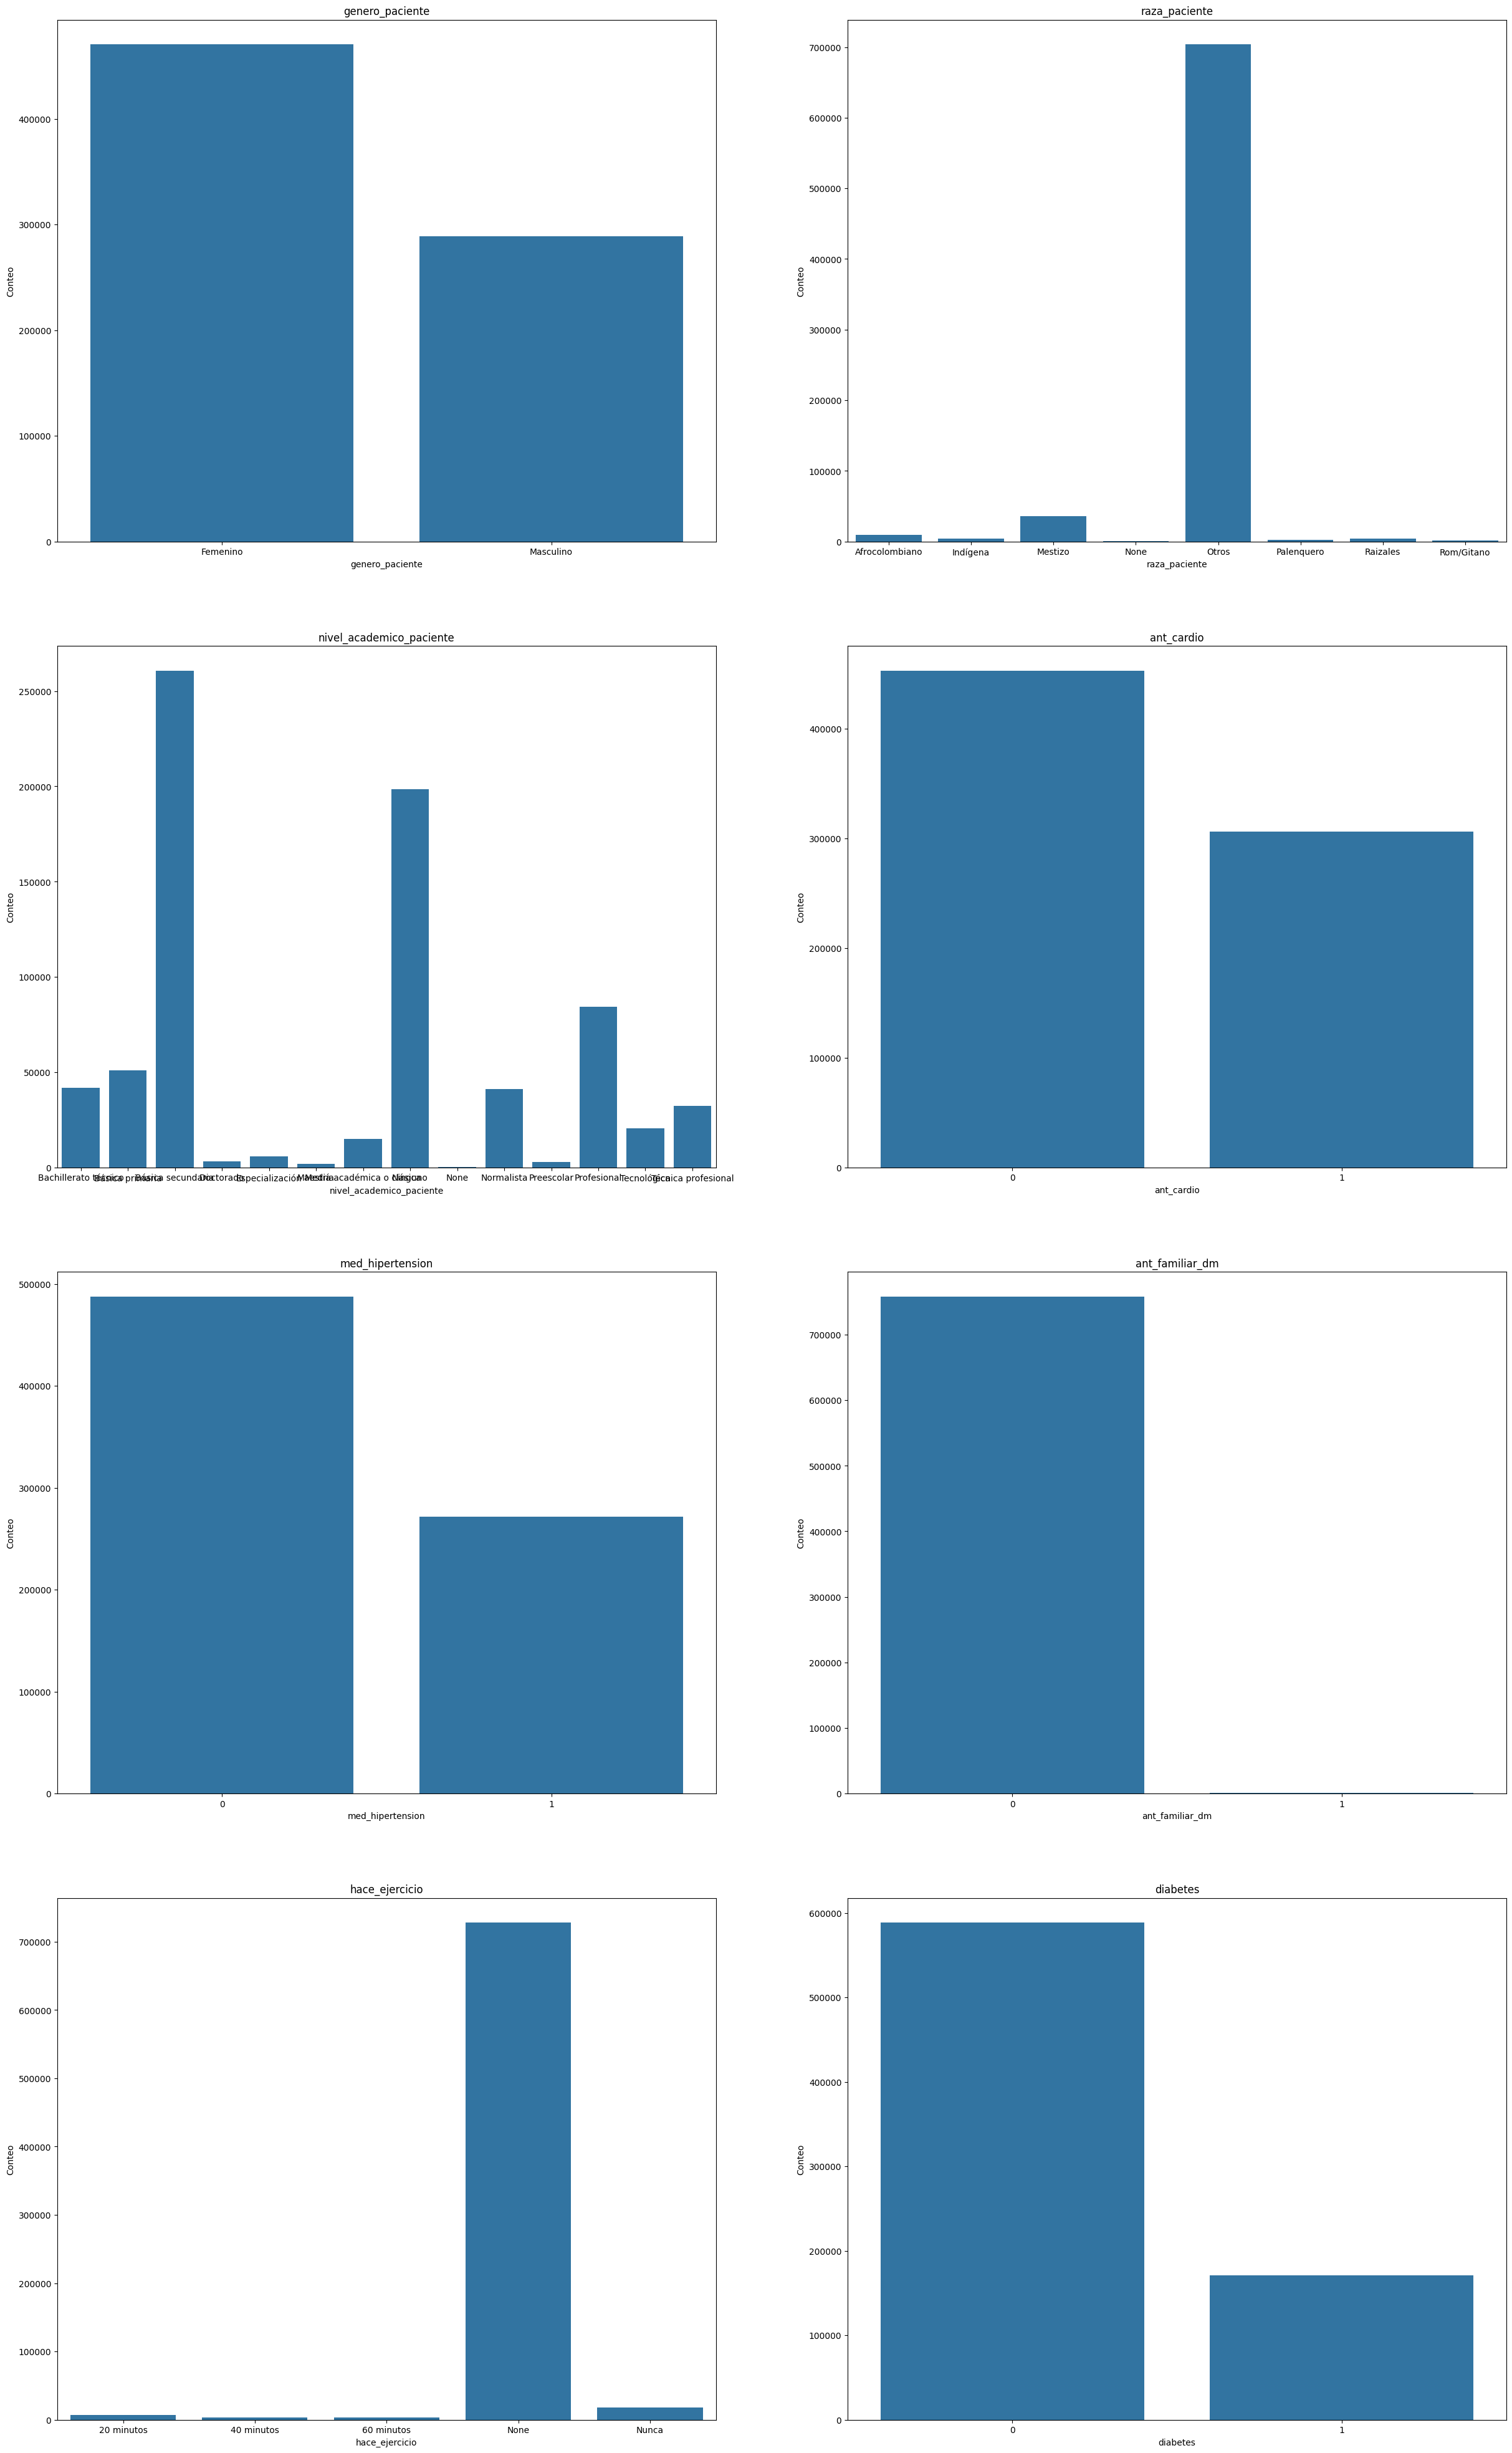

In [17]:
print('Conteos de cada una de las categorias')
fig, axes = graficador.create_subplots_one_var_group(data = df_categorico, n_cols = 2, n_rows = 4, graph= sns.barplot, fig_size=(30,50))
plt.show()

## Two Variables

In [23]:
print('Grafico de dispersion para cada par de variables')
sns.pairplot(df_numerico)
plt.show()

Grafico de dispersion para cada par de variables


Matriz de correlaciones


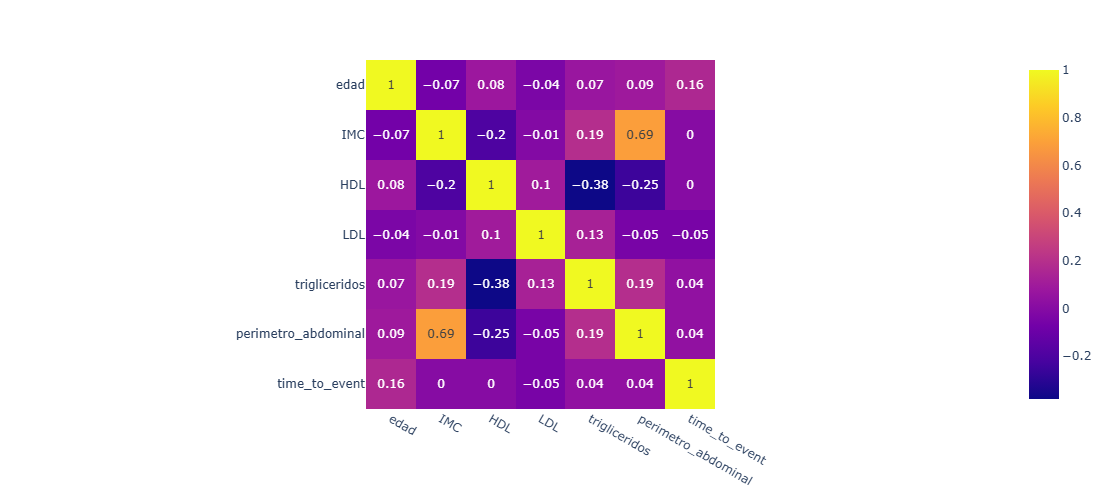

In [19]:
print('Matriz de correlaciones')
px.imshow(np.round(df_numerico.corr(),2), text_auto=True, height=500, width=700)

In [20]:
print('Matriz de covarianza')
df_numerico.cov()

Matriz de covarianza


edad        IMC         HDL          LDL  \
edad                 256.166582  -4.877292   13.611220   -26.277135   
IMC                   -4.877292  18.561541   -9.490844    -0.887526   
HDL                   13.611220  -9.490844  119.086412    41.028336   
LDL                  -26.277135  -0.887526   41.028336  1362.309031   
trigliceridos         73.391234  50.994298 -254.316350   303.721604   
perimetro_abdominal   15.124282  34.027589  -30.759817   -22.293824   
time_to_event         35.030866   0.023025    0.530948   -25.520152   

                     trigliceridos  perimetro_abdominal  time_to_event  
edad                     73.391234            15.124282      35.030866  
IMC                      50.994298            34.027589       0.023025  
HDL                    -254.316350           -30.759817       0.530948  
LDL                     303.721604           -22.293824     -25.520152  
trigliceridos          3844.138186           134.072428      30.741623  
perimetro_abdominal     134.072428           131.107421       6.675996  
time_to_event            30.741623             6.675996     183.974864

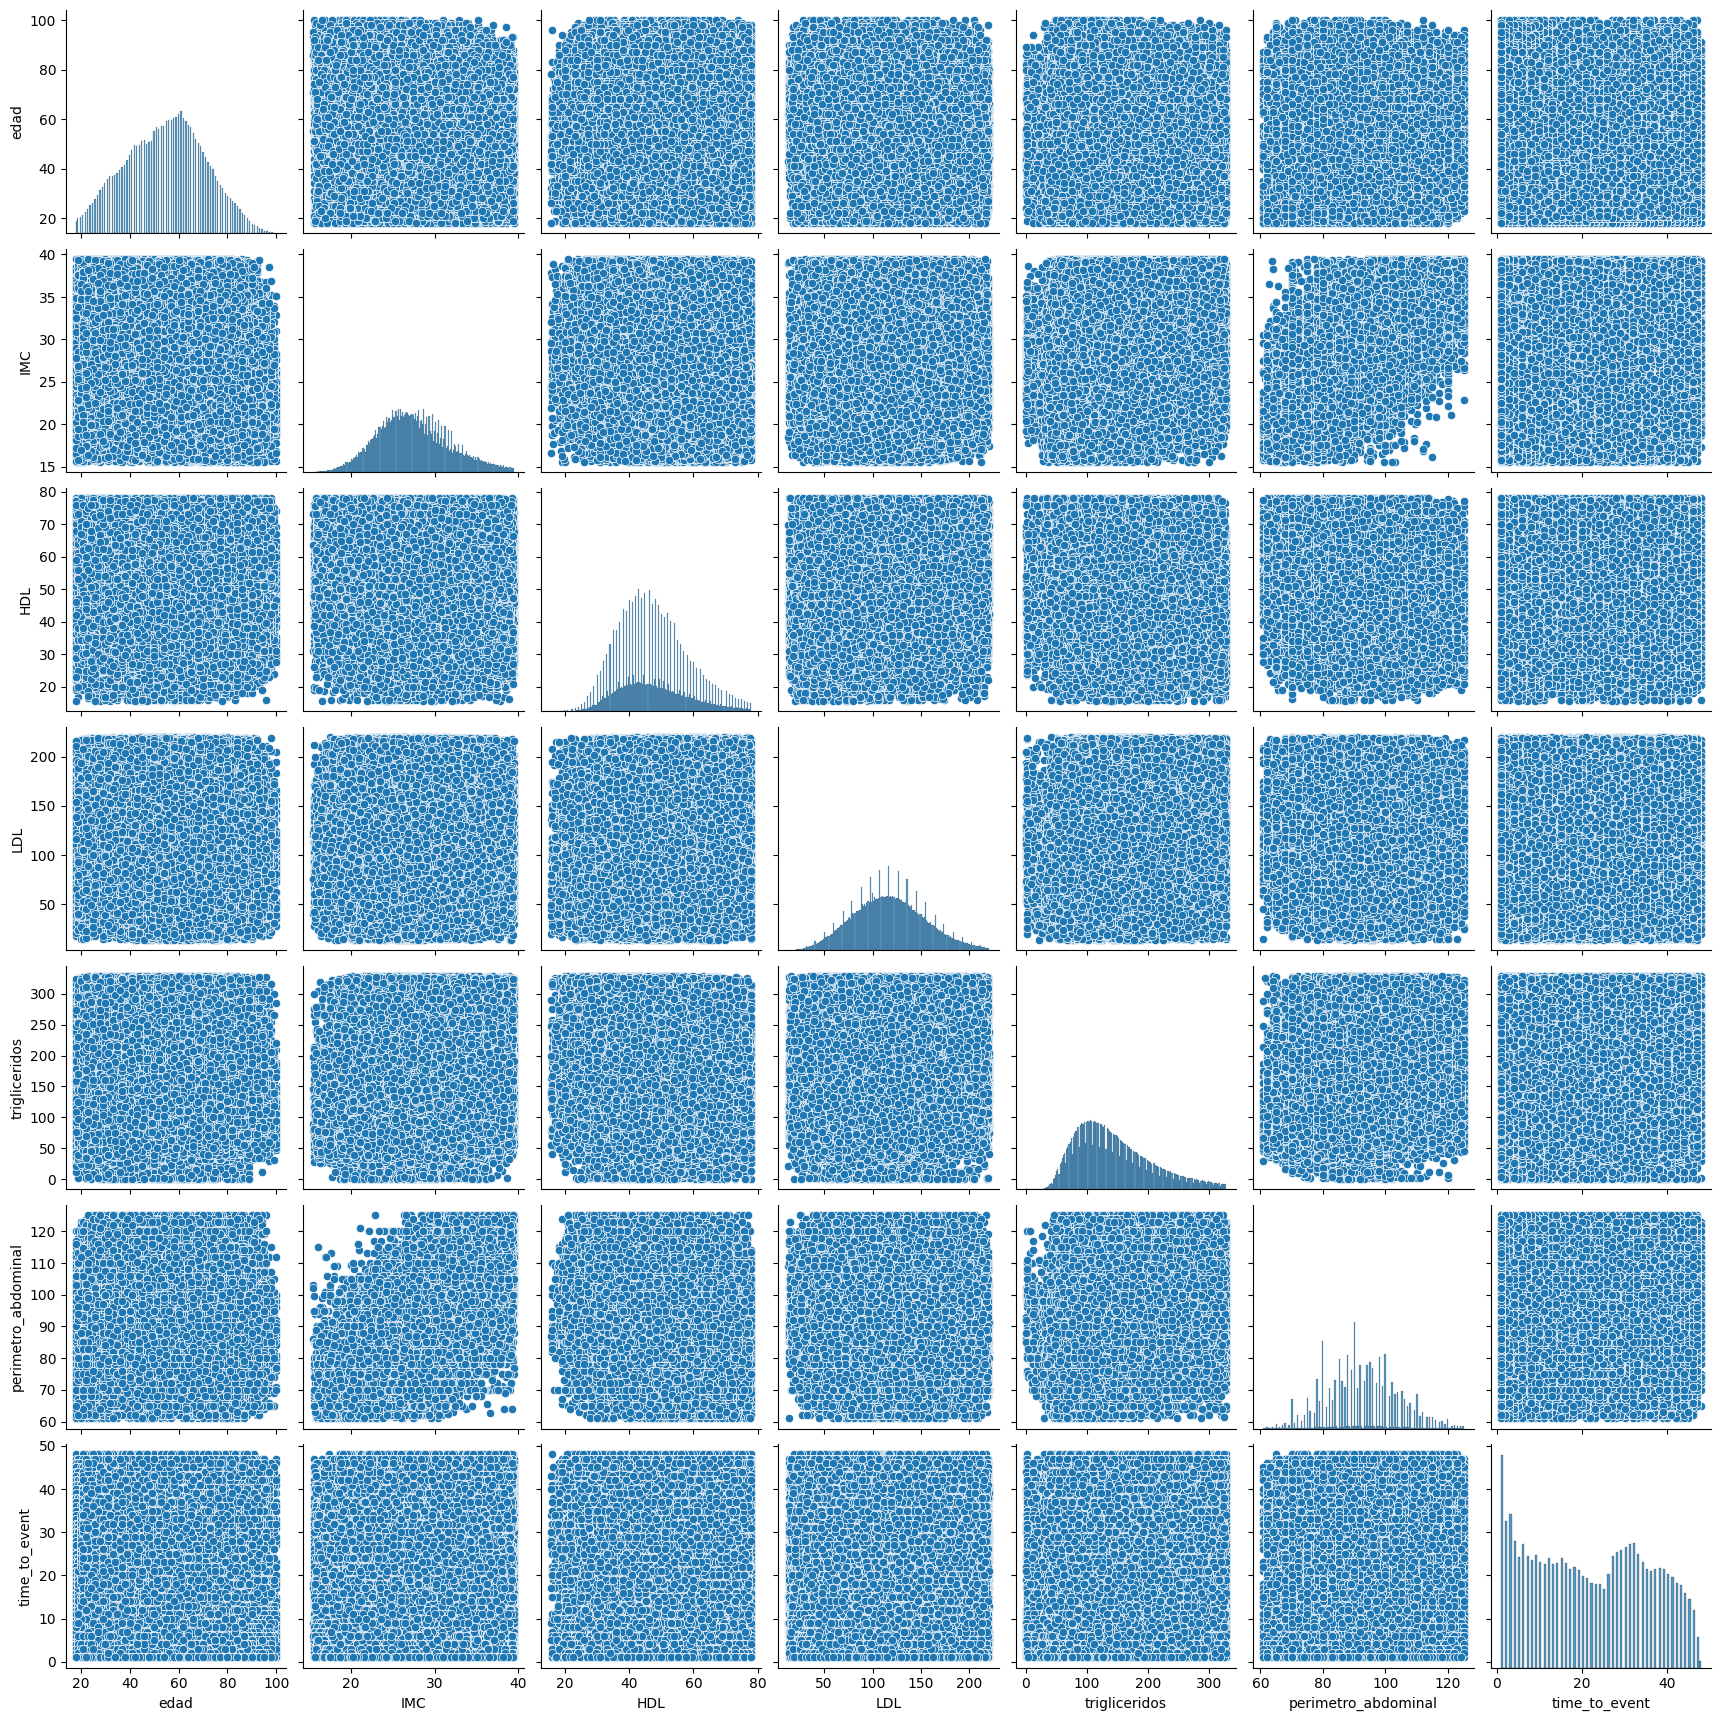

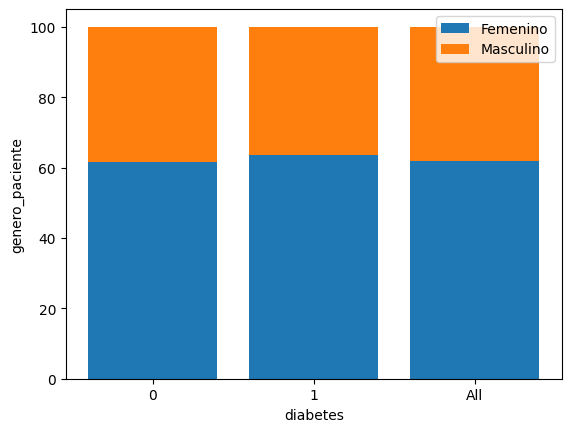

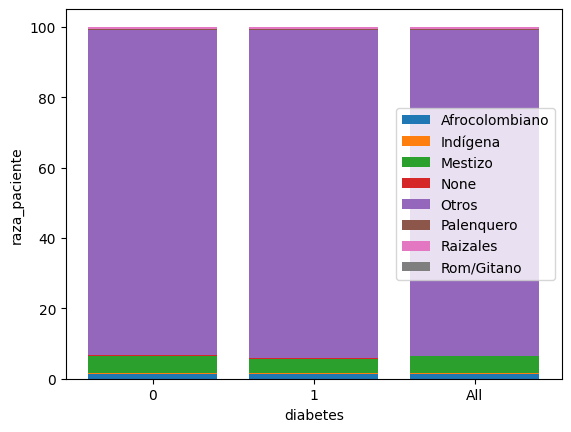

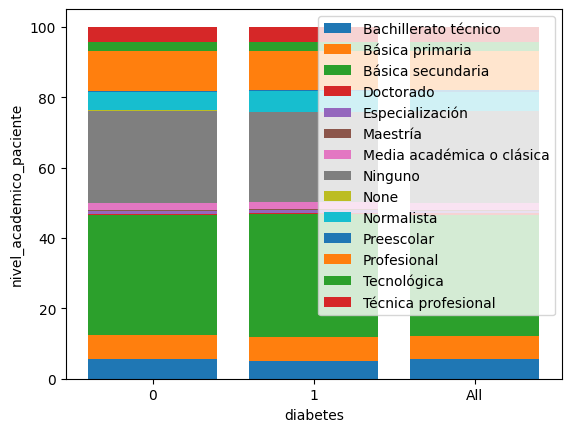

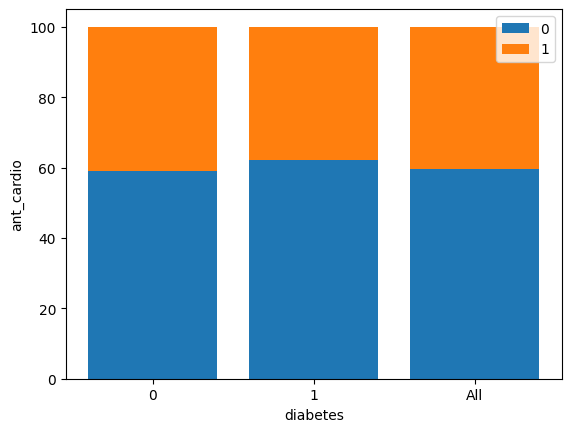

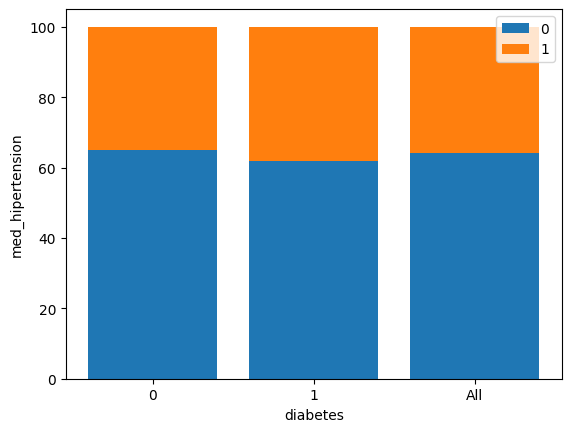

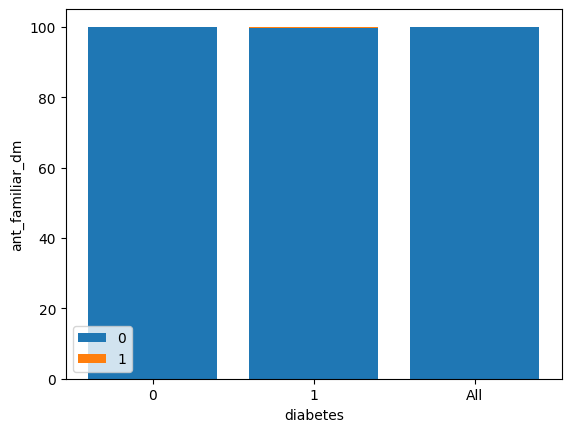

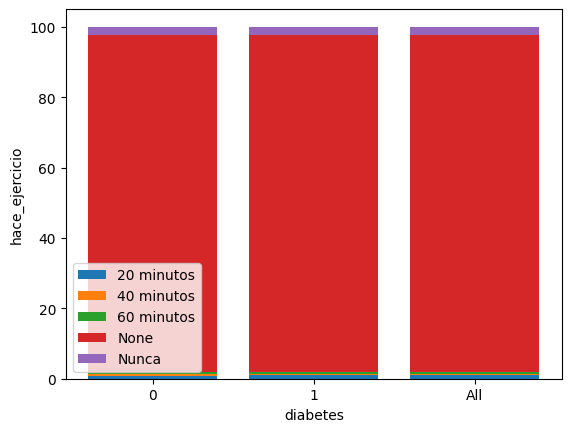

In [24]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    
    # Crear tabla con el perfil columna
    pc = round((pivot/ pivot.loc['All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pc)
    ax.set_xlabel(var2)
    ax.set_ylabel(column)
    plt.legend()


plt.show()

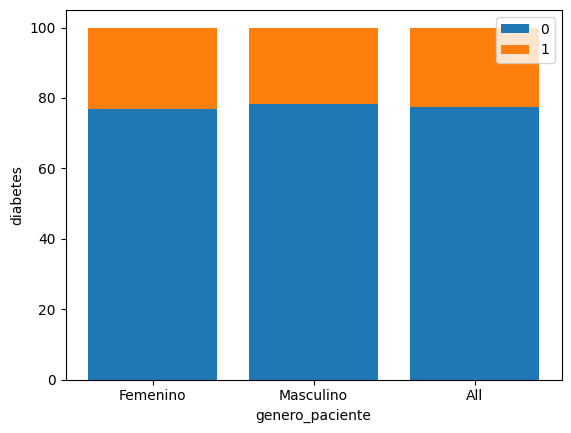

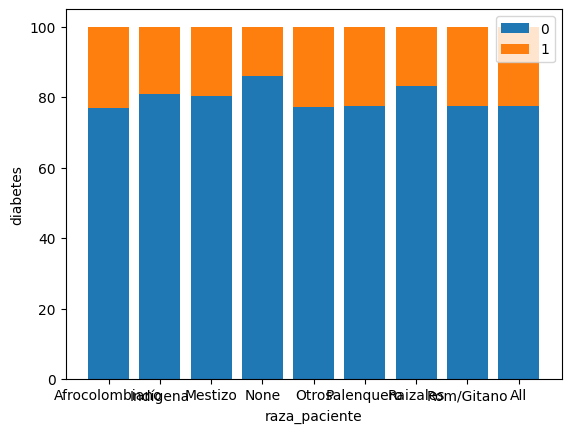

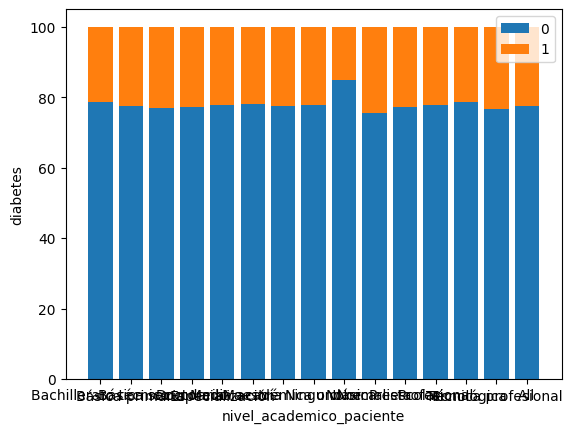

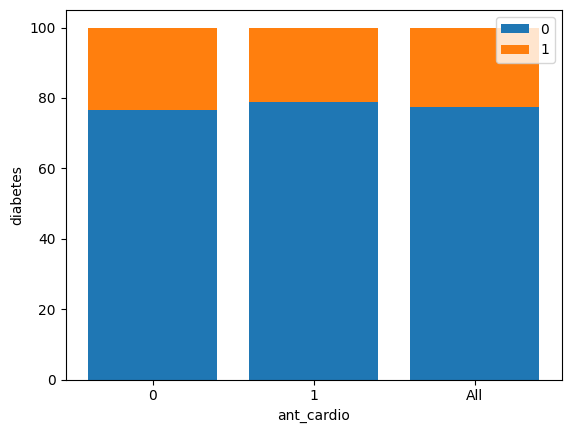

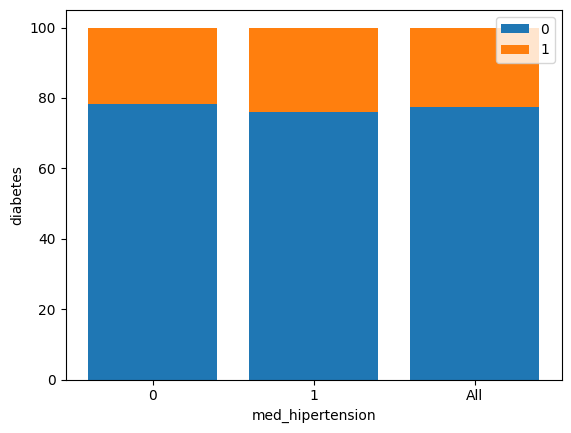

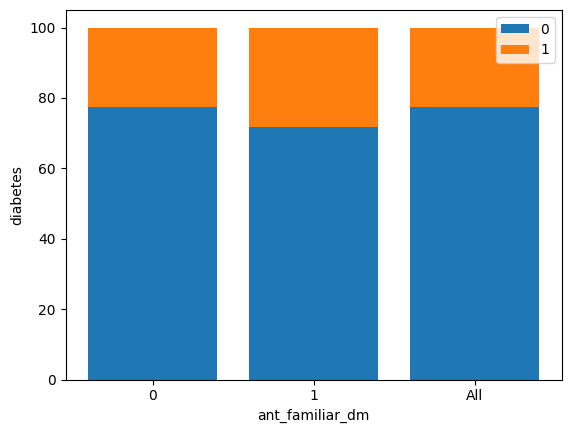

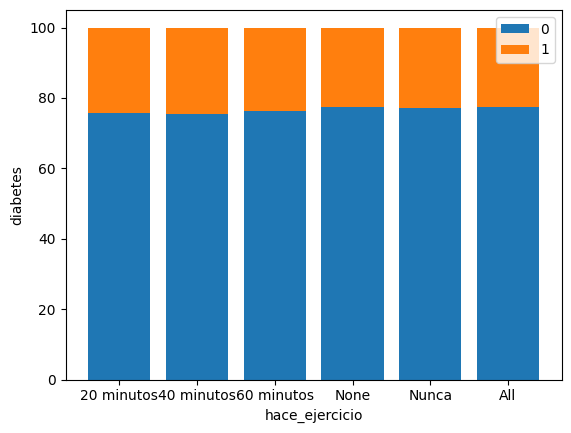

In [22]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    # Crear tabla con el perfil columna
    pf = round((pivot.T/ pivot.loc[:,'All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pf)
    ax.set_xlabel(column)
    ax.set_ylabel(var2)
    plt.legend()


plt.show()